In [1]:
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit, prange

In [2]:
from utils.generate_phrases import generate_random_phrase, generate_random_phrase_with_mutation, alphabet

In [3]:
def num_char_certo(y_true:str, y_pred:str):
    count = 0
    for i, letter in enumerate(y_true):
        if letter == y_pred[i]:
            count += 1
    
    count = count / len(y_true)
    return count

In [4]:
def genetic_drift(phrases, seed=2024):
    random.seed(seed)
    new_phrases = np.empty(len(phrases), dtype=object)
    for i in range(len(phrases)):
        new_phrases[i] = np.random.choice(phrases)
    return new_phrases

def crossover(new_phrases:np.array, c:float=0.9):
    '''
    Recombinação \n
    Pegar m% das frases, selecionar aleatoriamente 2 frases e trocar um pedaço delas dado um crossoverpoint aleatório
    '''
    n_phrases = len(new_phrases)
    phrase_size = len(new_phrases[0])
    for i in range(round(c * n_phrases)):
        crossover_point = np.random.randint(1, phrase_size - 1)
        index_phrase1, index_phrase2 = np.random.randint(0, n_phrases, size=2)

        phrase1 = new_phrases[index_phrase1]
        phrase2 = new_phrases[index_phrase2]

        new_phrase_1 = phrase1[:crossover_point] + phrase2[crossover_point:]
        new_phrase_2 = phrase2[:crossover_point] + phrase1[crossover_point:]

        new_phrases[index_phrase1] = new_phrase_1
        new_phrases[index_phrase2] = new_phrase_2
    
    return new_phrases

def selection(new_phrases, phrase):
    return max(new_phrases, key=lambda p: num_char_certo(phrase, p))

# A partir da implementação anterior implementar Recombinação
* Use frases mais longas, eg, em um alfabeto de 4
possibilidades, use strings de 15 caracteres

- Implementar “conjugação” de duas vias
- Com uma certa frequência, maior do que a da mutação
- Selecionar dois pais
- Duas strings dão origem a duas strings
- Ponto de corte entre frases

In [5]:
def plot_graphs_and_describe(full_gens, m_list):
    d = {}

    for i in range(len(full_gens)):
        d[f"M{m_list[i]}"] = full_gens[i]

    df = pd.DataFrame(d)

    print(df.describe())

    df.boxplot()
    plt.xticks(rotation=45)
    plt.ylabel("Generations")
    plt.xlabel("Mutation rate")
    plt.show()

In [ ]:
class Mokey:
    def __init__(self):
        self.new_phrases = []
        self.info = []

    def __migration__(self, new_phrases, m, pop_index):
        '''
        Take a random phrase from new_phrases in pop_index
        Take a random phrase from new_phrases in pop_index + 1
        Swap a this phrases
        '''
        n_phrases = len(new_phrases)
        next_pop = pop_index + 1 if pop_index + 1 < len(self.new_phrases) else 0
        for i in range(n_phrases):
            if np.random.rand() <= m:
                index_pop_j = np.random.randint(0, n_phrases)
                new_phrases[i] = self.new_phrases[next_pop][index_pop_j]
                self.new_phrases[next_pop][index_pop_j] = new_phrases[i]
        return new_phrases
    
    def next_generation(self, initial_phrases, new_phrases, phrase, u=0.1, c=0.9, m=0.2, n_phrases=50, gen=0, pop_index=0):
        if phrase in new_phrases:
            return initial_phrases, {"gen": gen, "reached": True}, new_phrases
        
        new_phrases = crossover(new_phrases, c)
        new_phrases = genetic_drift(new_phrases)
        if gen > 0:
            new_phrases = self.__migration__(new_phrases, m, pop_index)
        best_phrase = selection(new_phrases, phrase)
        
        new_phrases = np.array([generate_random_phrase_with_mutation(best_phrase, alphabet=alphabet, u=u) for _ in range(n_phrases)])
        return initial_phrases, {"gen": gen, "reached": False}, new_phrases
    
    def generate_phrases(self, phrase, u=[0.1, 0.2], c=[0.8, 0.9], m=[0.2, 0.3], n_phrases=[50, 50], gen_max=1e6, num_pops=1):
        for letter in phrase:
            if letter not in alphabet:
                raise ValueError(f"Letter {letter} not in alphabet")
        
        phrase_size = len(phrase)
        initial_phrases = [np.array([generate_random_phrase(phrase_size, alphabet) for _ in range(n_phrases[pop_index])]) for pop_index in range(num_pops)]
        self.new_phrases = [initial_phrases[pop_index].copy() for pop_index in range(num_pops)]
        self.info = [() for _ in range(num_pops)]
        d_info = [{} for _ in range(num_pops)]

        gen = 0
        for gen in range(int(gen_max)):
            for pop_index in range(num_pops):
                initial_phrases[pop_index], d_info[pop_index], self.new_phrases[pop_index] = self.next_generation(initial_phrases[pop_index], 
                                                                                                           self.new_phrases[pop_index], phrase, u[pop_index], c[pop_index],
                                                                                                           m[pop_index], n_phrases[pop_index], gen, pop_index=pop_index)
                if d_info[pop_index].get("reached") and not self.info[pop_index]:
                    self.info[pop_index] = (initial_phrases[pop_index], d_info[pop_index], self.new_phrases[pop_index])
        
        return self.info
    
    def run_exp(self, u, c, m_list, phrase, qntd_exp, n_phrases=5, num_pops=2):
        print("Generating phrases for different crossover rates: \n", m)
        med_gens = [[] for _ in range(num_pops)]
        full_gens = [[] for _ in range(num_pops)]
        t1 = time.time()
        gens = [[] for _ in range(num_pops)]
        t1_epoch = time.time()
        for m in m_list:
            for i in range(qntd_exp):
                d_info = self.generate_phrases(phrase, u, c, m, n_phrases, gen_max=1e7, num_pops=num_pops)

                for pop_index in range(num_pops):
                    gens[pop_index].append(d_info[pop_index][1].get("gen"))
            t2_epoch = time.time()
            for pop_index in range(num_pops):
                print(f"Mutation rate: {m:.2f} | Mean generations: {round(np.mean(gens[pop_index]), 2):,} | Time taken: {t2_epoch-t1_epoch:.2f}s")

            for pop_index in range(num_pops):
                med_gens[pop_index].append(np.mean(gens[pop_index]))
                full_gens[pop_index].append(gens[pop_index])
        t2 = time.time()
        for pop_index in range(num_pops):
            print("Mean generations: ", med_gens[pop_index])
        print("Time taken: ", t2-t1)

        for pop_index in range(num_pops):
            m_list = [m[pop_index]]
            plt.plot(m_list, med_gens[num_pops])
            plt.plot(m_list, med_gens[num_pops], '*')
            plt.ylabel("Mean generations")
            plt.xlabel("Crossover rate")
            plt.show()

            plot_graphs_and_describe(full_gens[num_pops], m_list)

Mean generations: 2.1333333333333333
            M0.2
count  30.000000
mean    2.133333
std     0.628810
min     1.000000
25%     2.000000
50%     2.000000
75%     2.000000
max     4.000000


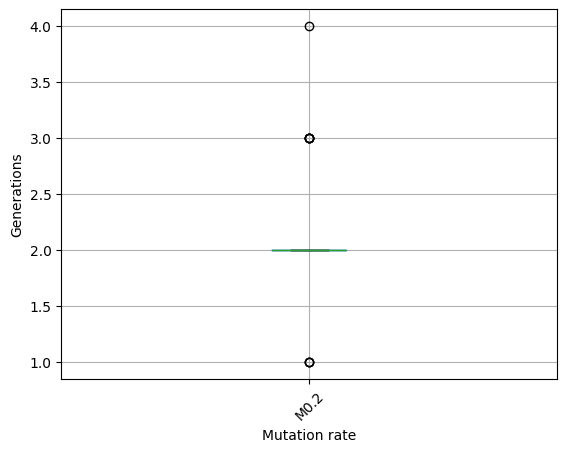

Mean generations: 1.8666666666666667
            M0.1
count  30.000000
mean    1.866667
std     0.507416
min     1.000000
25%     2.000000
50%     2.000000
75%     2.000000
max     3.000000


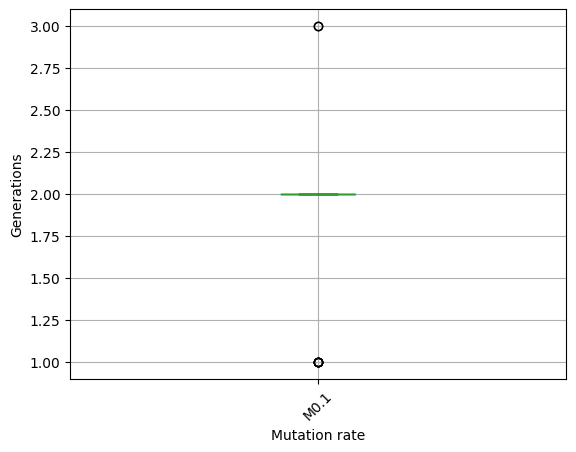

In [23]:
phrase = 'GAGCCCG'#AACGAGCTTTGCGTCT'
n_phrases = [100, 100]
u = [0.25, 0.3]
c = [0.75, 0.8]
m = [0.2, 0.1]
n_exp = 30
num_pops = 2
seed = 2024
random.seed(seed)
np.random.seed(seed)

gens = [[] for _ in range(num_pops)]

mokeys = Mokey()
for i in range(n_exp):
    d_info = mokeys.generate_phrases(phrase, u=u, c=c, m=m, n_phrases=n_phrases, num_pops=num_pops)
    for pop_index in range(num_pops):
        gens[pop_index].append(d_info[pop_index][1].get("gen"))

    # print(f"Took {gen:,} generations to generate the phrase '{phrase}' from '{initial_phrases}'")
    # print("\n Mutated to '{new_phrases}'")

for pop_index in range(num_pops):
    mean_gen = sum(gens[pop_index]) / len(gens[pop_index])
    print(f"Mean generations: {mean_gen:,}")

    plot_graphs_and_describe([gens[pop_index]], [m[pop_index]])

In [ ]:
phrase = 'GAGCCCGAACGAGCTTTGCGTCT'
n_phrases = [100, 100]
u = [0.25, 0.3]
c = [0.75, 0.8]
m = [[0.2, 0.1]]
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

mokeys = Mokey()
mokeys.run_exp(u, c, m, phrase, n_exp, n_phrases=n_phrases)

Generating phrases for different crossover rates: 
 [0.2, 0.1]


In [ ]:
phrase = 'GAGCCCGAACGAGCTTTGCGTCT'
n_phrases = [100, 100]
u = [0.25, 0.3]
c = [0.75, 0.8]
m_list = [[i, i + np.random.rand() * 0.1] for i in np.arange(0.25, 0.95, 0.1)]
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

mokeys = Mokey()
mokeys.run_exp(u, c, m_list, phrase, n_exp, n_phrases=n_phrases)